 # **<center>  Lab 6- Shape from Focus** </center> 
### **Problem Statement:**

In this experiment, We are given a set of images which are captured using different camera lens settings, thus resulting in different degrees of optical blur. We use these images to determine the depth of each pixel in the image using the shape from focus (SFF) algorithm discussed in class. Display the 3D structure of the scene using the calculated depth values. We use sum-modified Laplacian (SML) operator as focus measure and ∆d = 50.50. Observe the output 3D structure for q = 0, 1 and 2, where q is the size of the neighbourhood for the SML window as defined in class.

### 1. Importing required Libraries and Reading the stack.mat file

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.io import loadmat

In [22]:
stack = loadmat('stack.mat')
num_frames = int(stack['numframes'])
frames = {}
# store the images in a dictionary for easier access later
for key in stack.keys():
    if key[:5] == 'frame':
        frames[int(key[5:])] = stack[key]
# delta d as mentioned in the assignment PDF
del_d = 50.5

###2. Double derivative operators
Define the partial double derivative operators in discrete 2D space.

In [23]:
ly=np.zeros((3,3))
lx=np.zeros((3,3))
ly[0]= [0,  1, 0]
ly[1]= [0, -2, 0]
ly[2]= [0,  1, 0]

lx[0] = [0,  0, 0]
lx[1] = [1, -2, 1]
lx[2] = [0,  0, 0]

###3. Function for Calculating the Kernel to obtain SML
This function calculates the kernel to obtain the sum modified Laplcian from the modified Laplacian values. For a given $q$, the kernel is chosen to be a matrix of size $(2q+1)\times (2q+1) $ with each entry being 1.

In [24]:
def sum_kernel(q):
    k = 2*q+1
    return np.ones((k,k))

###4. Function for zero padding of the image
This function performs padding on the image so that the kernel sits properly on the image and after convolution the output image is of the same size as that of input image.

Padding can be done in two types:


*   Zero padding (filling the outer rows by zeros)
*   Extension (filling of the outer rows with pixels similar to the pixels in the image)

Here, we are using zero padding.



In [25]:
def zero_pad_image(image, d):
    # get the shape of the image
    [x, y] = np.shape(image)
    # array of zeros
    zero_padded_image = np.zeros((x+2*d, y+2*d))
    # fill the middle of it with the given image
    zero_padded_image[d:-d, d:-d] = image
    return zero_padded_image

###5. Function to preform Convolution 
Given the padded image and the blur kernel, this function performs the convolution of the padded image and blur kernel and produces the output image.

In [26]:
def convolve_2D(image, kernel, correlation=True):
    # The correlation parameter is to distinguish between
    # correlation and convolution. For a Gaussian kernel, it
    # makes no difference as the symmetry of the Gaussian kernel means
    # correlation and convolution give the same results

    # get the shape of the image
    [x, y] = np.shape(image)
    w = len(kernel)
    d = w//2
    # if the kernel is of size (1,1), just return the original image
    if d == 0:
        filtered_image = kernel*image
    # get the zero padded image
    else:
      filtered_image = np.zeros((x-2*d, y-2*d))
      for i in range(d, x-d):
        for j in range(d, y-d):
          # extract image patch
          patch = image[i-d:i+d+1, j-d:j+d+1]
          # multiply image patch with the kernel, sum and store
          filtered_image[i-d, j-d] = np.sum(patch*kernel)
                
    return filtered_image

###6. Function for Modified Laplacian 
This function defines the modified laplacian operator ($ML$). Given an image $I$, its $ML_I$ is defined as:
$ML_I=|I_{xx}| + |I_{yy}|$  

where $|I_{xx}|$ and $|I_{yy}|$ are the discrete 2D double derivatives of the image. Before calculating the $ML$ , the image is zero padded as needed and ***'$valid$'*** convolution is performed.

In [27]:
def mod_laplacian(image, d):
    if d != 0:
        # pad the image if zero padding is non zero
        padded_image = zero_pad_image(image, d)
    else:
        padded_image = image
    # get the 2D double derivatives
    image_xx = convolve_2D(padded_image, lx)
    image_yy = convolve_2D(padded_image, ly)
    # sum their absolute values
    return np.abs(image_xx)+np.abs(image_yy)

###7. Function for Sum Modified Laplacian
Define the Sum Modified Laplacian ($SML$) operator. Given an image $I$ and a given value of $q \geq 0 $, its $SML$ at pixel ($x,y$) is defined as
$SML_I(x,y)=\sum_{i=-q}^{i=q} \sum_{j=-q}^{j=q} ML_I (x+i,y+j)$

where $ML_I$ is$ML$ of $I$ . Using a larger $q$ is more robust but can merge depth information from nearby pixels. For a pixel, assume the frame which has the maximum ($SML$) at that pixel to be the frame in focus and use it for depth estimation.

In [28]:

def sum_modified_laplacian(image, q):
    # get the kernel to sum over a window of size k*k
    # where k is (2q+1)
    summer = sum_kernel(q)
    # get the modified laplacian
    # padding by q+1 zeroes before modified laplacian ensures
    # the sum modified laplacian is of the same shape as the
    # original image
    modified_laplacian_image = mod_laplacian(image, q+1)
    if q == 0:
        # if the window size is just one pixel, sum modified laplacian
        # and modified laplacian are the same
        return modified_laplacian_image
    else:
        # else sum  over modified laplacian values over a window of size k*k
        return convolve_2D(modified_laplacian_image, summer)

###8. Function for Sharp Image
Once it has been calculated for each pixel location the frame where it is in focus, form the focused image by choosing the corresponding pixel value at that location from the frame in focus.

In [29]:
def sharpened_image(max_shaprness_frames, frames_dictionary):
    # shape of max_shaprness_frames is the same as the shape
    # of each individual frame. max_shaprness_frames[i, j]
    # contains the frame index at which the maximum focus
    # score is obtained
    x, y = np.shape(max_shaprness_frames)
    sharp_image = np.zeros((x, y))
    for i in range(x):
        for j in range(y):
            # get the image frame at which the maximum focus score is obtained
            frame = max_shaprness_frames[i, j]+1
            # assign the pixel value of the sharp image to be the pixel value
            # of the corresponding pixel in the frame with the highest score
            sharp_image[i, j] = frames_dictionary[frame][i, j]
    return sharp_image

#Estimating Depth and Obtaining Sharp Images
For a pixel, estimate the depth using the frame which has the highest focus score. If the frame at which pixel ($x,y$) attains maximum focus score is $k$, the depth of that pixel is estimated to be
$depth(i,j)=(k-1)\Delta d$  i.e., frame$1$ is assumed to be at zero depth. Also, store the frame indices for each pixel where the highest focus score occurs and use it to estimate the sharp image.



In [32]:
sml_vals = {}
depths = {}
max_shaprness_frames = {}
q_vals = [0, 1, 2]
x, y = np.shape(frames[1])
for q in q_vals:
    # iterate through each q value
    stacked = np.zeros((x, y, num_frames))
    print(f"calculating sml for q = {q}")
    for i in range(num_frames):
        # make a stack comprising of the SML values for each frame
        stacked[:, :, i] = sum_modified_laplacian(frames[i+1], q)
    # store the sml stacks in a dictionary
    sml_vals[q] = stacked
    # get the pixelwise frame index with the maximum sharpness scores
    max_shaprness_frames[q] = np.argmax(stacked, axis=2)
    # calculate depth from the frame index
    depths[q] = max_shaprness_frames[q]*del_d
sharp_images = {}
for q in q_vals:
    # generate the sharp images and store them in a dictionary
    sharp_images[q] = sharpened_image(max_shaprness_frames[q], frames)

calculating sml for q = 1
calculating sml for q = 2


Let's observe images

Text(0.5, 1.0, '$q$ = 2')

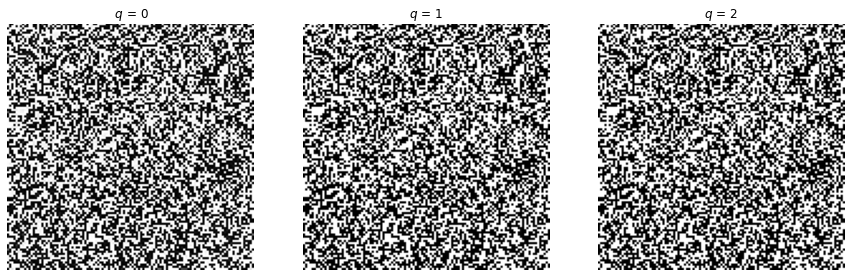

In [43]:
#code for displaying multiple images in one figure

# create figure
fig = plt.figure(figsize=(15,8))

# setting values to rows and column variables
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(sharp_images[0],'gray')
plt.axis('off')
plt.title(f" $q$ = {q_vals[0]}")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(sharp_images[1],'gray')
plt.axis('off')
plt.title(f"$q$ = {q_vals[1]}")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
# showing image
plt.imshow(sharp_images[2],'gray')
plt.axis('off')
plt.title(f"$q$ = {q_vals[2]}")

Let's observe the difference in the images.

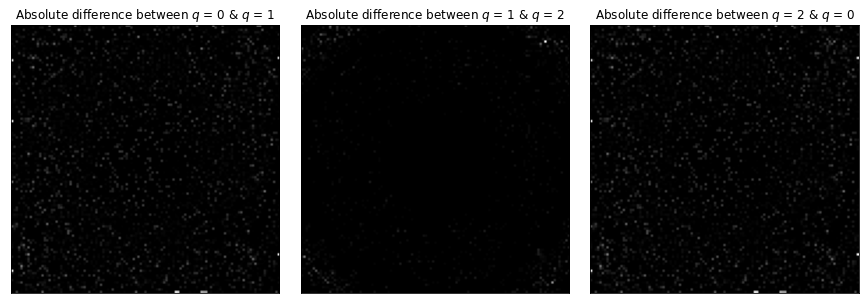

In [34]:
fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(12, 9), constrained_layout=True)
ax4.set_xticks([])
ax4.set_yticks([])
ax5.set_xticks([])
ax5.set_yticks([])
ax6.set_xticks([])
ax6.set_yticks([])
ax4.imshow(np.abs(sharp_images[0]-sharp_images[1]), 'gray')
ax4.title.set_text(f"Absolute difference between $q$ = {q_vals[0]} & $q$ = {q_vals[1]}")
ax5.imshow(np.abs(sharp_images[1]-sharp_images[2]), 'gray')
ax5.title.set_text(f"Absolute difference between $q$ = {q_vals[1]} & $q$ = {q_vals[2]}")
ax6.imshow(np.abs(sharp_images[2]-sharp_images[0]), 'gray')
ax6.title.set_text(f"Absolute difference between $q$ = {q_vals[2]} & $q$ = {q_vals[0]}")

Let's observe 3d images:

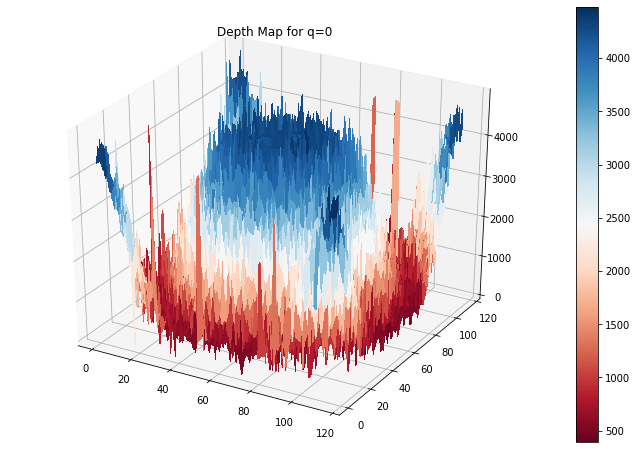

In [40]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
x, y = np.shape(frames[1])
X, Y = np.meshgrid(np.arange(x)+1, np.arange(y)+1)
surf = ax.plot_surface(X, Y, depths[0], cmap='RdBu', linewidth=0, antialiased=False)
title = rf"Depth Map for q=0"
plt.title(title)
fig.colorbar(surf)
plt.show()

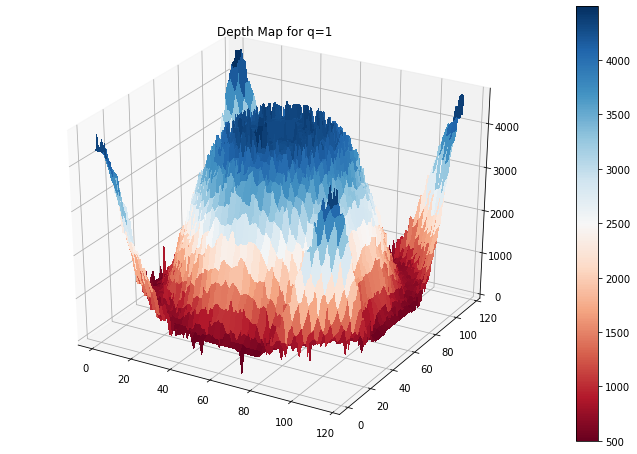

In [41]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
x, y = np.shape(frames[1])
X, Y = np.meshgrid(np.arange(x)+1, np.arange(y)+1)
surf = ax.plot_surface(X, Y, depths[1], cmap='RdBu', linewidth=0, antialiased=False)
title = rf"Depth Map for q=1"
plt.title(title)
fig.colorbar(surf)
plt.show()

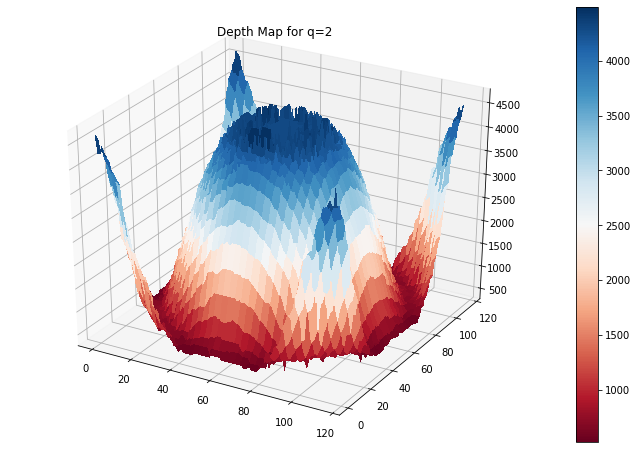

In [42]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
x, y = np.shape(frames[1])
X, Y = np.meshgrid(np.arange(x)+1, np.arange(y)+1)
surf = ax.plot_surface(X, Y, depths[2], cmap='RdBu', linewidth=0, antialiased=False)
title = rf"Depth Map for q=2"
plt.title(title)
fig.colorbar(surf)
plt.show()

#**Observations:**

By looking at the results obtained, the following observations can be made.
The following observations can be made.

* Not much difference is observed in the sharp image estimates obtained for the different values of q. 

* The absolute differences are also mostly zero everywhere.

* However, the depth estimates are different. As q
increases, we get smoother estimates.

* The sharp image estimates look somewhat good as the images had a lot of texture. 
